# Vehicle Detection Project:

## Imports :

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from os import listdir
from scipy.ndimage.measurements import label

## Define some functions :

In [2]:
# Define a function that applies color conversion to an RGB image
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#Define a funtion that draw boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Load data :

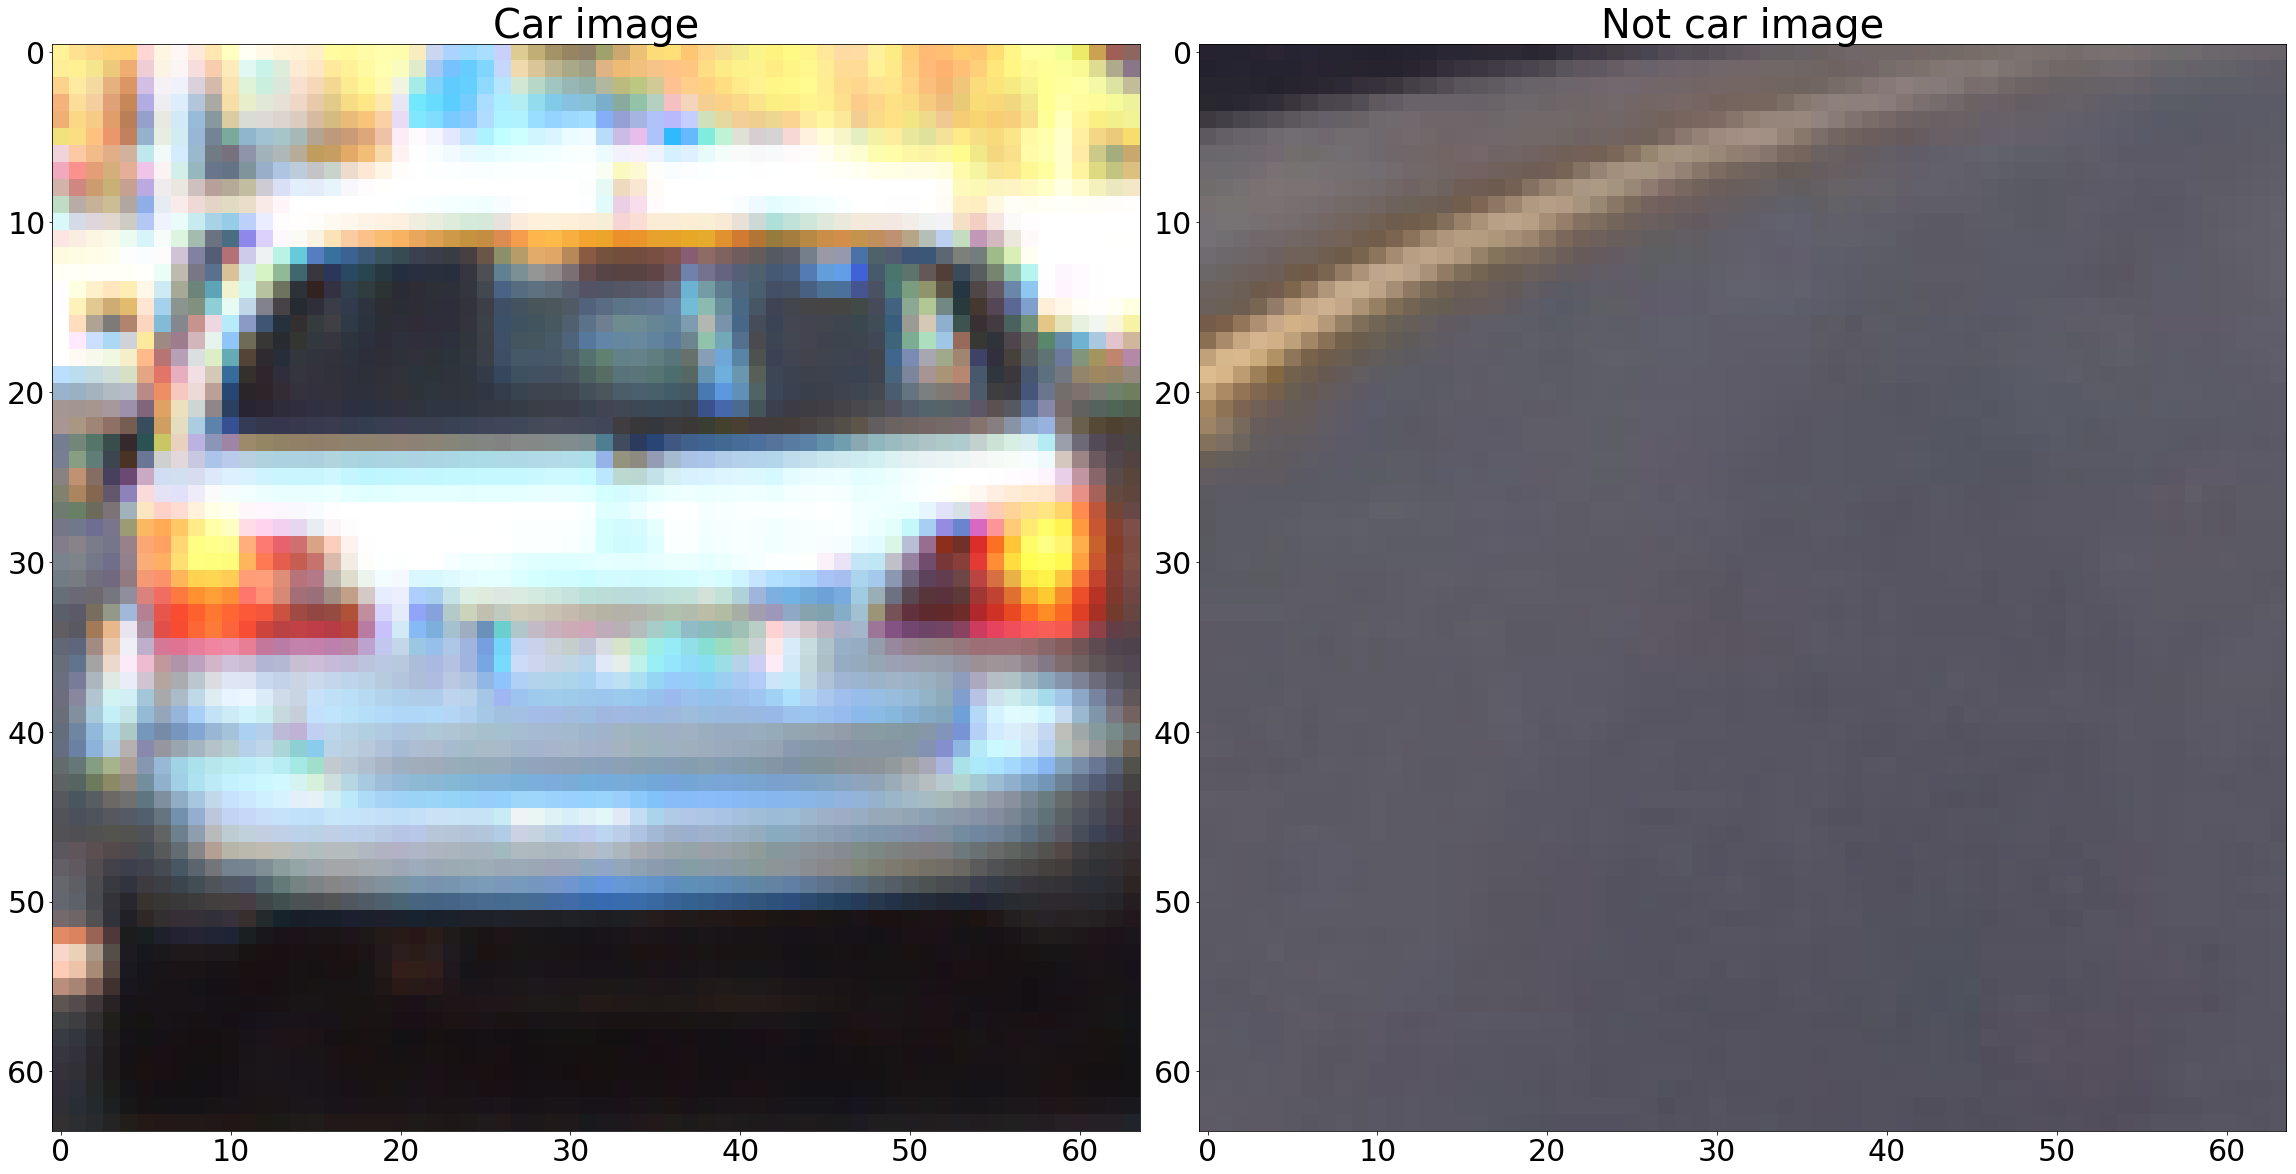

In [3]:
# Read in cars and notcars
vehicles_folder = './images/vehicles/'
non_vehicles_folder = './images/non-vehicles/'
vehicles_subfolders = listdir(vehicles_folder)
non_vehicles_subfolders = listdir(non_vehicles_folder)
cars = []
notcars = []
for subfolder in vehicles_subfolders:
    images = glob.glob(vehicles_folder+subfolder+'/*.png')
    for image in images:
        cars.append(image.split('\\')[-1])
for subfolder in non_vehicles_subfolders:
    images = glob.glob(non_vehicles_folder+subfolder+'/*.png')
    for image in images:
        notcars.append(image.split('\\')[-1])

# Reduce the sample size because
sample_size = 8000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

#Visualize a car and a notcar images
car_image = mpimg.imread(cars[100])
notcar_image = mpimg.imread(notcars[100])

fig = plt.figure(figsize=(32,32))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car image',fontsize=40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Not car image',fontsize=40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
fig.tight_layout()
plt.show()

## HOG features:

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


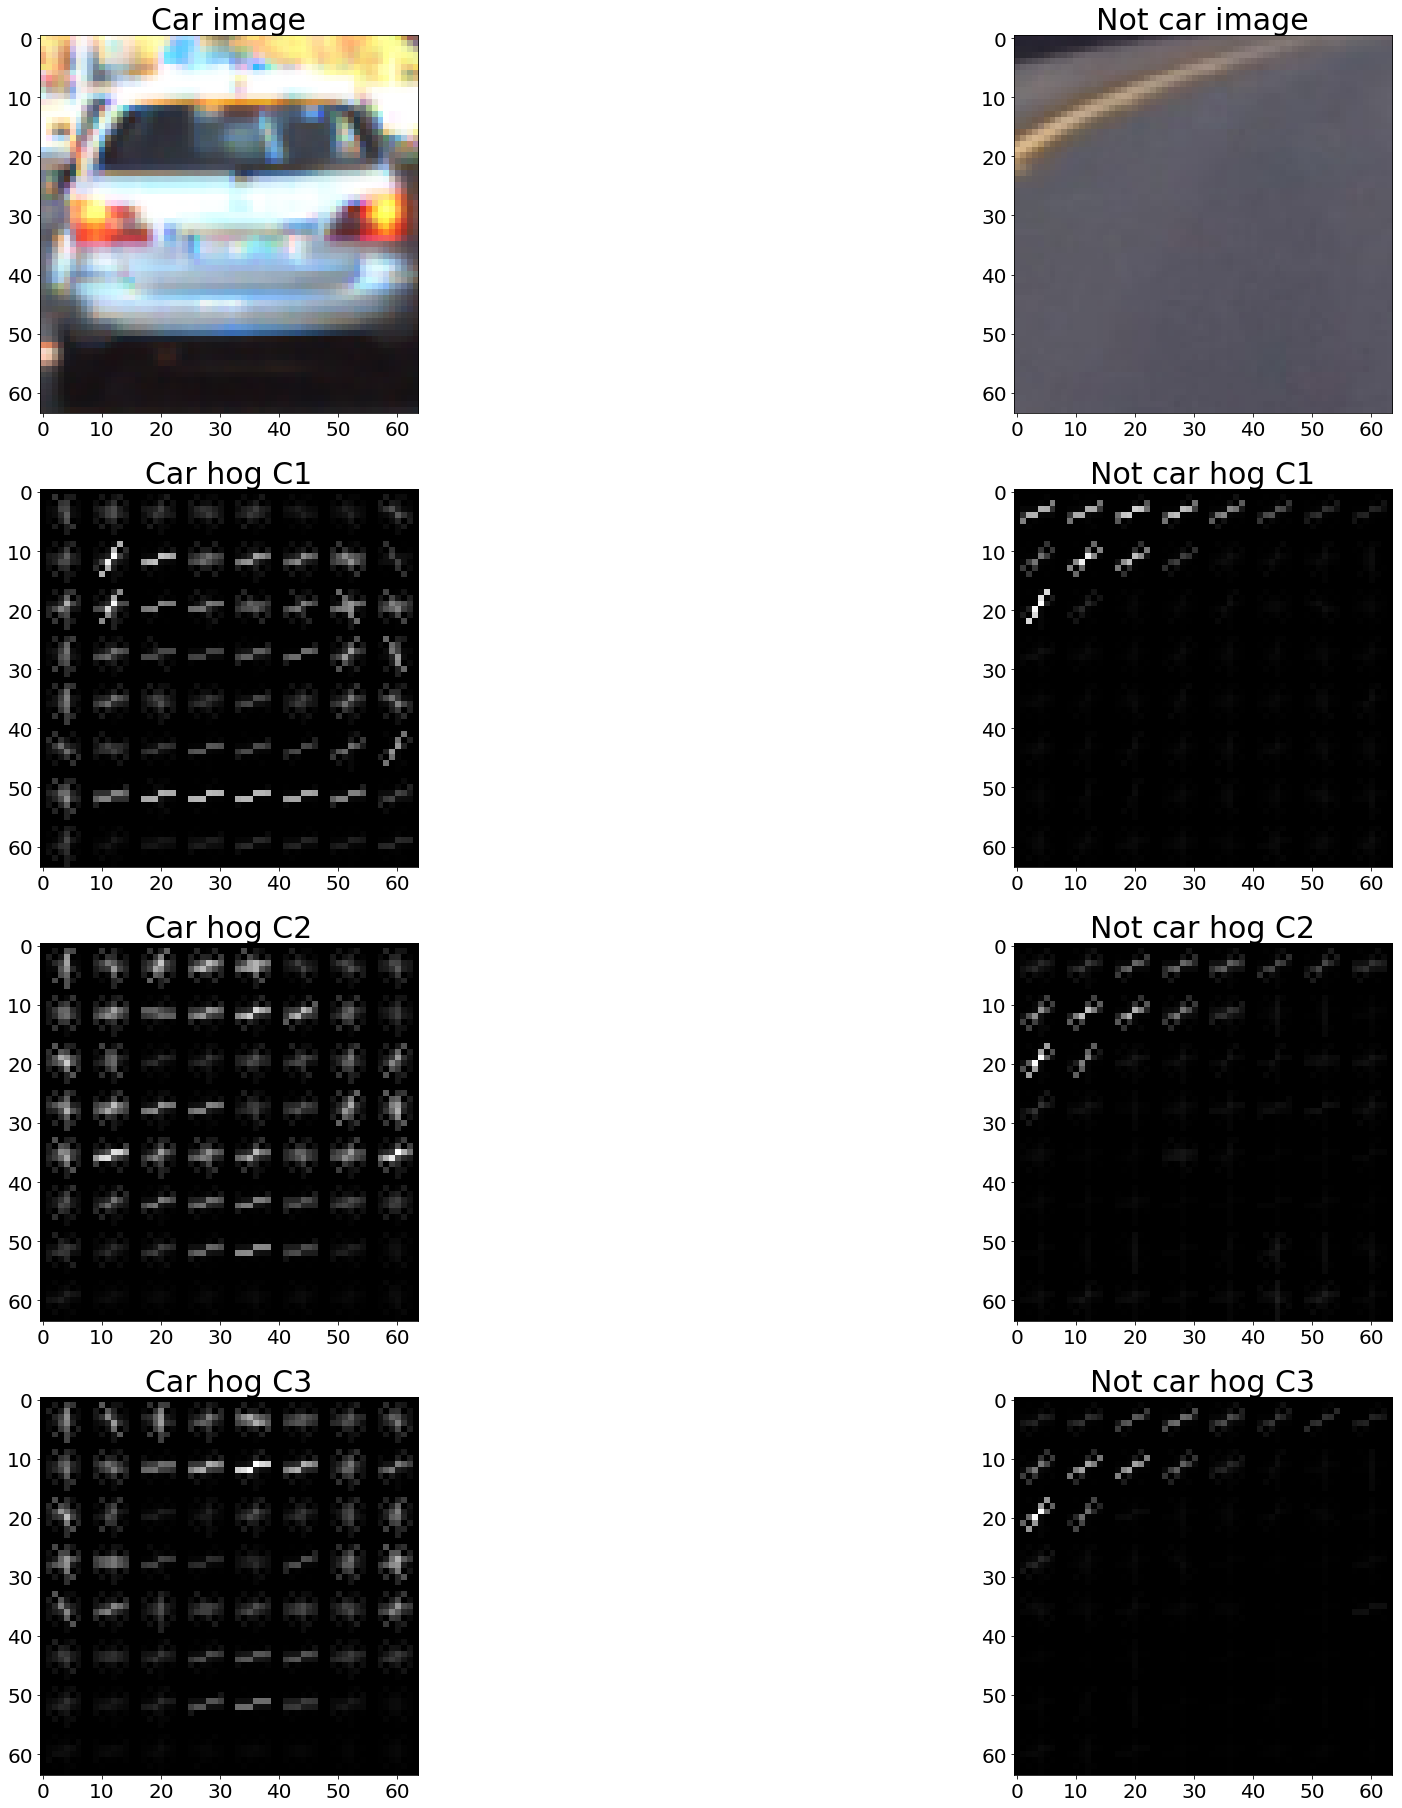

In [4]:
### Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

#convert the image from RGB to YCrCb
car_image_conv = convert_color(car_image, conv='RGB2YCrCb')
notcar_image_conv = convert_color(notcar_image, conv='RGB2YCrCb')

car_hog = np.zeros_like(car_image)
notcar_hog = np.zeros_like(notcar_image)

# get the hog  images
for i in range(3):
    features_car, car_hog[:,:,i] = get_hog_features(car_image_conv[:,:,i], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    features_notcar, notcar_hog[:,:,i] = get_hog_features(notcar_image_conv[:,:,i], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig = plt.figure(figsize=(32,32))
plt.subplot(421)
plt.imshow(car_image)
plt.title('Car image', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(422)
plt.imshow(notcar_image)
plt.title('Not car image', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(423)
plt.imshow(car_hog[:,:,0], cmap='gray')
plt.title('Car hog C1', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(424)
plt.imshow(notcar_hog[:,:,0], cmap='gray')
plt.title('Not car hog C1', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(425)
plt.imshow(car_hog[:,:,1], cmap='gray')
plt.title('Car hog C2', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(426)
plt.imshow(notcar_hog[:,:,1], cmap='gray')
plt.title('Not car hog C2', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(427)
plt.imshow(car_hog[:,:,2], cmap='gray')
plt.title('Car hog C3', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.subplot(428)
plt.imshow(notcar_hog[:,:,2], cmap='gray')
plt.title('Not car hog C3', size=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

## Classifier :

In [66]:
### Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
37.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9975


## HOG Subsampling:

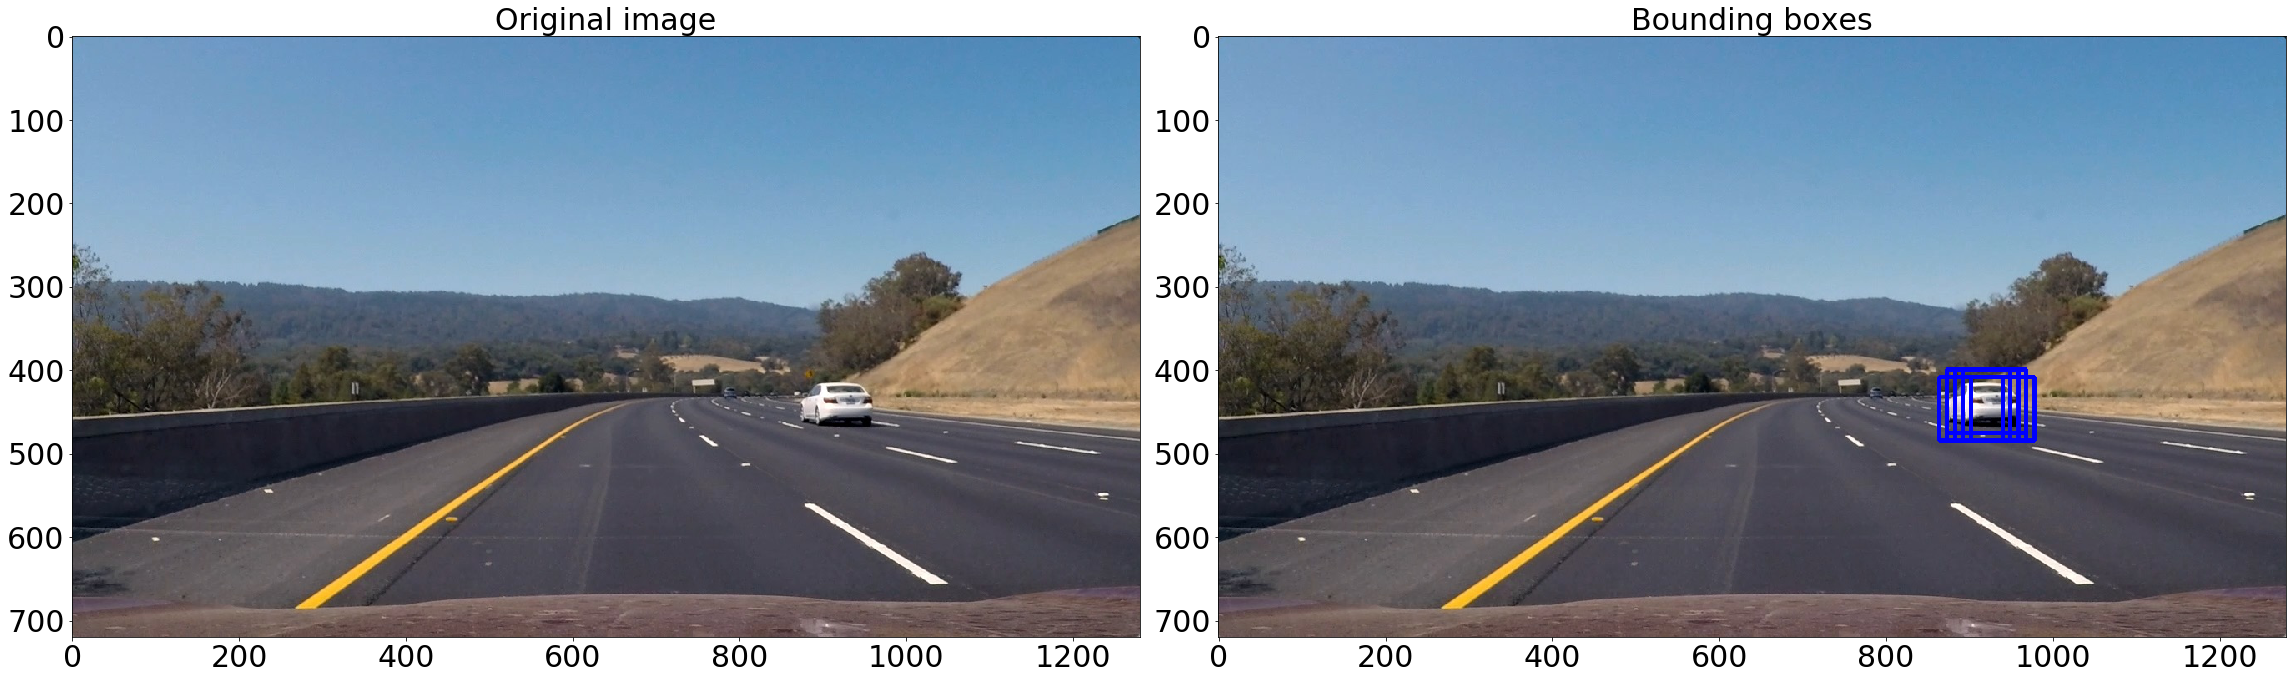

In [125]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def hog_sub(img, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = 1+(nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            test_prediction = y_proba = clf.predict_proba(test_features)
            
            #if True:
            if test_prediction[0][1] > 0.7:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return window_list
    


image = mpimg.imread('./test_images/test3.jpg')
# find which windows contain a car
ystart = 420
ystop = 770
cells_per_step = 1
scale = 4
hot_windows = hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)            
ystart = 400
ystop = 720
cells_per_step = 1
scale = 3
hot_windows.extend(hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

ystart = 380
ystop = 600
cells_per_step = 1
scale = 2
hot_windows.extend(hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

ystart = 380
ystop = 500
cells_per_step = 1
scale = 1.2
hot_windows.extend(hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    
out_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=4) 
fig = plt.figure(figsize=(32,32))
plt.subplot(121)
plt.imshow(image)
plt.title('Original image', size=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.subplot(122)
plt.imshow(out_img)
plt.title('Bounding boxes', fontsize=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
fig.tight_layout()
plt.show()
plt.show()

## Heat map :

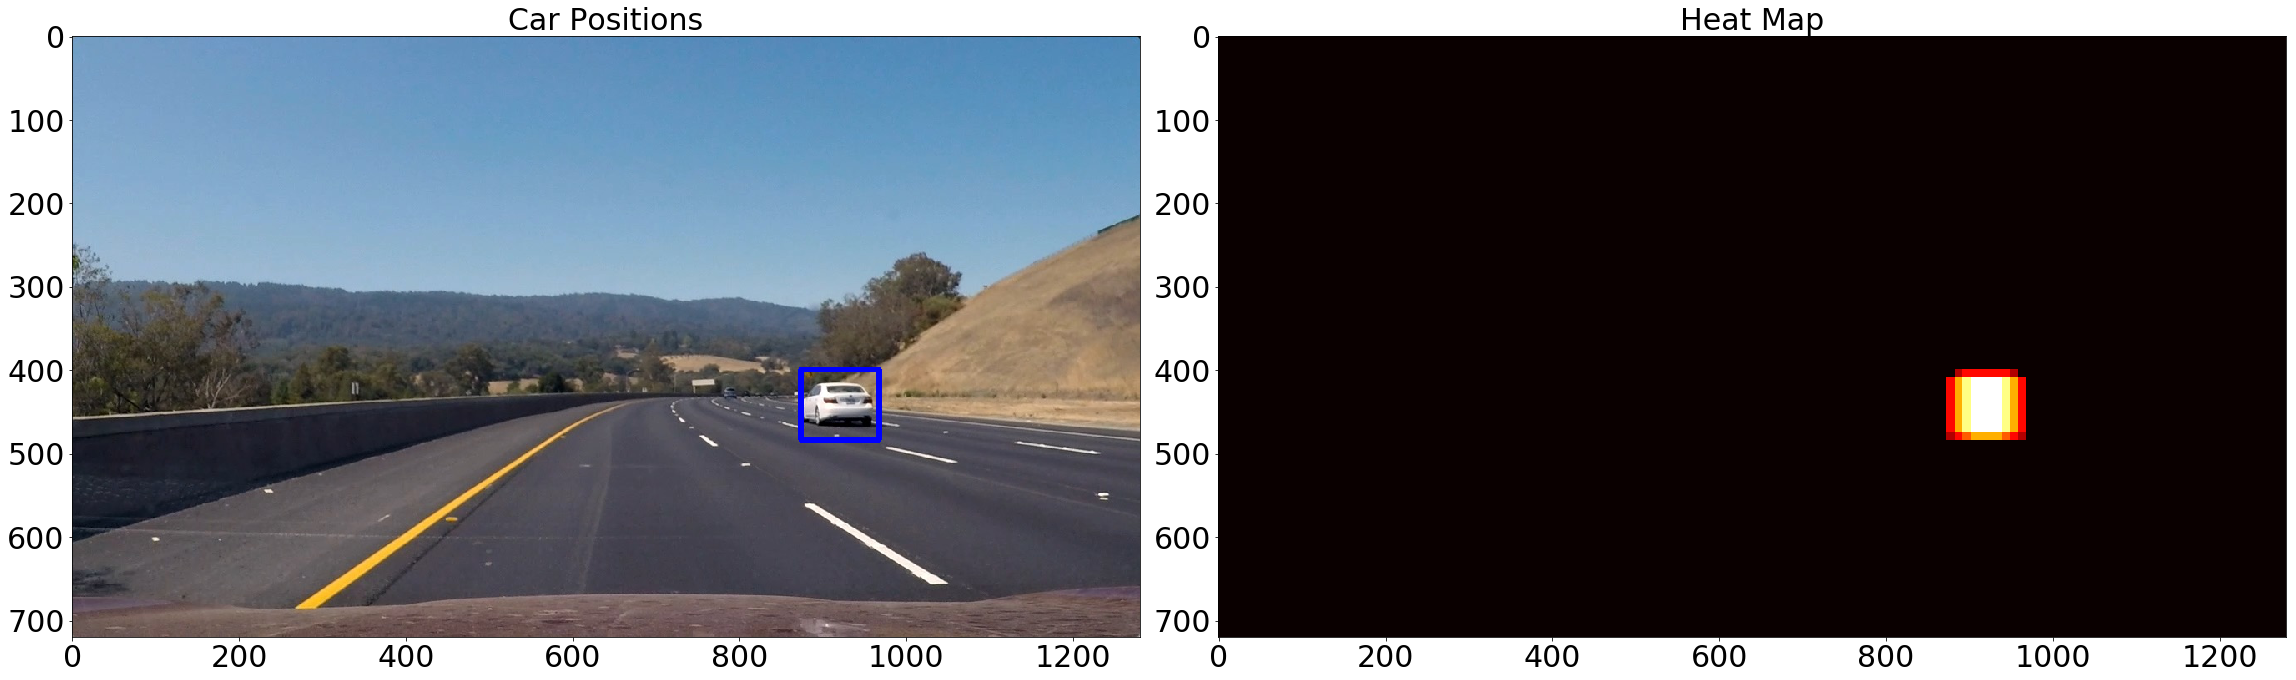

In [123]:
# list of boxes for the image shown above
box_list = hot_windows

# Read in image similar to one shown above 
image = mpimg.imread('./test_images/test3.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    windows = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        windows.append((bbox[0], bbox[1]))
    # Return the image
    return img, windows

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, windows = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(32,32))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
fig.tight_layout()
plt.show()

## Image pipeline :

In [126]:
# Create a pipeline that finds cars and draw a box around each of them

### Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()
ystart = 400
ystop = 656
global_hot_windows = [] #windows  from current and previous frames
i=0
n_windows = np.zeros(5)

def find_cars(image, htmap = False):
    global i,svc, X_scaler, color_space, orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,spatial_feat,hist_feat,hog_feat, global_hot_windows
    
    #Scale the image between 0 and 1
    image_scaled = image.astype(np.float32)/255
    
    # find which windows contain a car
    ystart = 420
    ystop = 770
    cells_per_step = 1
    scale = 4
    hot_windows = hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)            
    ystart = 400
    ystop = 720
    cells_per_step = 1
    scale = 3
    hot_windows.extend(hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 380
    ystop = 600
    cells_per_step = 1
    scale = 2
    hot_windows.extend(hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 380
    ystop = 500
    cells_per_step = 1
    scale = 1.2
    hot_windows.extend(hog_sub(image, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    heat = np.zeros_like(image_scaled[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, windows = draw_labeled_bboxes(np.copy(image), labels)
    
    j=i%5
    global_hot_windows.extend(windows)
    if i >= 5:
            
        heat = np.zeros_like(image_scaled[:,:,0]).astype(np.float)
        
        # Add heat to each box in box list
        heat = add_heat(heat, global_hot_windows)
        
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,2)
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img, windows2 = draw_labeled_bboxes(np.copy(image), labels)
        
        # remove old boxes and keep only boxes from the previous 5 frames
        global_hot_windows = global_hot_windows[np.int_(n_windows[j]):len(global_hot_windows)]
        
    n_windows[j] = len(windows)
    i += 1
    if htmap == True:
        return draw_img, heatmap
    else:
        return draw_img

## Test the pipeline on an image:

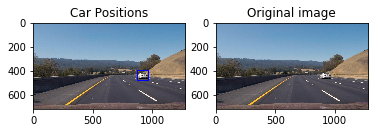

In [127]:
test_image = mpimg.imread('./test_images/test3.jpg')
global_hot_windows = []
i=0
n_windows = np.zeros(5)
result = find_cars(test_image)

plt.fig = plt.figure()
plt.subplot(121)
plt.imshow(result)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(test_image)
plt.title('Original image')
#fig.tight_layout()
plt.show()

## Test the pipeline on frames of a video:

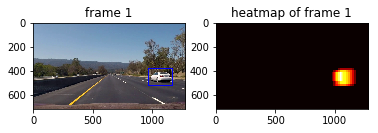

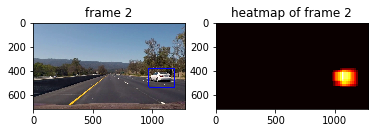

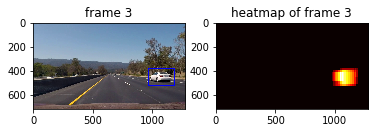

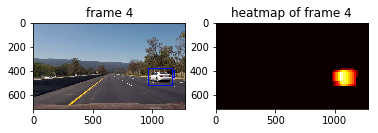

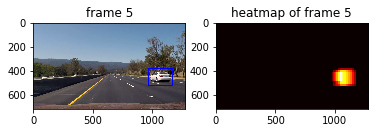

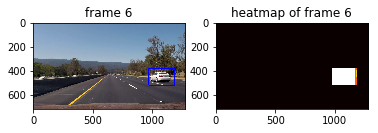

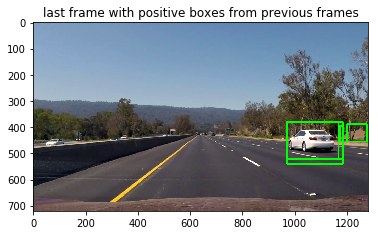

In [128]:
# Load images
images = glob.glob('./video frames/*.jpg')

global_hot_windows = []
i=0
n_windows = np.zeros(5)

m = 1
for image in images:
    frame = mpimg.imread(image)
    result, heatmap = find_cars(frame, htmap=True)
    plt.fig = plt.figure(m)
    plt.subplot(121)
    plt.imshow(result)
    plt.title('frame ' + str(m))
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('heatmap of frame '+ str(m))
    m +=1

plt.figure(m)
last_frame = mpimg.imread(images[-1])
for window in global_hot_windows:
    last_frame = cv2.rectangle(last_frame, window[0], window[1], (0,255,0), 6)

plt.imshow(last_frame)
plt.title('last frame with positive boxes from previous frames')
plt.show()
    


## Test the pipeline on a short video:

In [131]:
# Aplly the pipeline on a video

# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip

global_hot_windows = []
i=0
n_windows = np.zeros(5)

white_output = 'output_test_video.mp4'
clip = VideoFileClip("test_video.mp4")
white_clip = clip.fl_image(find_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [01:00<00:01,  1.55s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

CPU times: user 1min, sys: 360 ms, total: 1min
Wall time: 1min 2s


## Apply the pipeline on the video:

In [132]:
# Aplly the pipeline on a video

# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip

global_hot_windows = [] #windows  from current and previous frames
i=0
n_windows = np.zeros(5)

white_output = 'output_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(find_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [33:53<00:01,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 33min 53s, sys: 12 s, total: 34min 5s
Wall time: 33min 54s
